In [130]:
__author__ = 'Joan Najita, Arjun Dey, Robert Nikutta, Stepahnie Juneau, NOAO Data Lab Team'
__version__ = '20180529' # yyyymmdd
__datasets__ = 'gaia2ls5_all.csv'

# Test of Cross-Matches between DESI Imaging Legacy Surveys and GAIA
by Arjun Dey, Joan Najita, Stéphanie Juneau, Robert Nikutta and the NOAO Data Lab Team

In this notebook, we investigate  

NOAO Data Lab products and services used here:
<ul>
<li>the Legacy Survey (LS) DR5 database</li>
<li>Jupyter Notebook Server</li>
<li>Query Manager</li>
</ul>

### Table of contents
* [0. Disclaimer & attribution](#attribution)
* [1. Introduction](#introduction)
* [2. Imports & setup](#import)
* [3. Authentication](#auth)
* [4. Query DECaLS Tractor Photometry Catalog](#query)
* [5. Plot Results](#plots)
* [6. Full Size LS DR3 Query](#fullsize)
* [7. User Contributions](#users)
* [8. Image Cutouts for Subsets of Objects](#cutouts)

<a class="anchor" id="attribution"></a>
# 0. Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

<a class="anchor" id="introduction"></a>
# 1. Introduction



## 1.1 Information about LS

You can read more about DECaLS on the Data Lab survey page [(here)](http://datalab.noao.edu/decals/ls.php) and on the Legacy Survey team website [(here)](http://legacysurvey.org). The fourth data release (DR4) includes data from MzLS and BASS, covering the northern portion of the Legacy Survey imaging footprint. The fifth data release (DR5) largely supersedes DR3, including only DECaLS observations, and as described in this [NOAO Currents Article](https://www.noao.edu/currents/201710.html#lsdr5).

## 1.2 Information about GAIA

Brief overview plus links.


<a class="anchor" id="import"></a>
# 2. Import

In [171]:
# Python 2/3 compatibility
from __future__ import print_function # to use print() as a function in Python 2

try:
    input = raw_input # use 'input' function in both Python 2 and 3
except NameError:
    pass

# std lib
from astropy.table import Table

# 3rd party
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
from dl.helpers import crossmatch
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, helpers
from getpass import getpass
print('Done importing')

Done importing


In [17]:
## TEMPORARY: latest version of the 'convert' function from the Data Lab Helpers (will be updated in June 2018)

# std lib
from functools import partial
from io import BytesIO

# 3rd party
from collections import OrderedDict
from pandas import read_csv
from astropy.table import Table
from astropy.io.votable import parse_single_table
import astropy.units as u

def convert(inp,outfmt='pandas',verbose=False,**kwargs):

    """Convert input `inp` to a data structure defined by `outfmt`.

    Parameters
    ----------
    inp : str
        String representation of the result of a query. Usually this
        is a CSV-formatted string, but can also be, e.g. an
        XML-formatted votable (as string)

    outfmt : str
        The desired data structure for converting `inp` to. Default:
        'pandas', which returns a Pandas dataframe. Other available
        conversions are:

          string - no conversion
          array - Numpy array
          structarray - Numpy structured array (also called record array)
          table - Astropy Table
          votable - Astropy VOtable
    
        For outfmt='votable', the input string must be an
        XML-formatted string. For all other values, as CSV-formatted
        string.

    verbose : bool
        If True, print status message after conversion. Default: False

    kwargs : optional params
        Will be passed as **kwargs to the converter method.


    Example
    -------
    Convert a CSV-formatted string to a Pandas dataframe

    .. code-block:: python

       arr = convert(inp,'array')
       arr.shape  # arr is a Numpy array

       df = convert(inp,outfmt='pandas')
       df.head()  # df is as Pandas dataframe, with all its methods

       df = convert(inp,'pandas',na_values='Infinity') # na_values is a kwarg; adds 'Infinity' to list of values converter to np.inf

    """
    
    # map outfmt container types to a tuple:
    # (:func:`queryClient.query()` fmt-value, descriptive title,
    # processing function for the result string)
    mapping = OrderedDict([
        ('string'      , ('csv',     'CSV formatted table as a string', lambda x: x.getvalue())),
        ('array'       , ('csv',     'Numpy array',                     partial(np.loadtxt,unpack=False,skiprows=1,delimiter=','))),
        ('structarray' , ('csv',     'Numpy structured / record array', partial(np.genfromtxt,dtype=float,delimiter=',',names=True))),
        ('pandas'      , ('csv',     'Pandas dataframe',                read_csv)),
        ('table'       , ('csv',     'Astropy Table',                   partial(Table.read,format='csv'))),
        ('votable'     , ('votable', 'Astropy VOtable',                 parse_single_table))
    ])

    b = BytesIO(inp.encode())
    output = mapping[outfmt][2](b,**kwargs)

    if isinstance(output,bytes):
        output = output.decode()
    
    if verbose:
        print("Returning %s" % mapping[outfmt][1])

    return output

<a class="anchor" id="auth"></a>
# 3. Authenticate & Set Profile

In [18]:
# To save to virtual space, you need to log in your account (not anonymous)
#token = ac.login('anonymous')
token = ac.login(input("Enter user name: "),getpass("Enter password: "))
print('Done getting token')

Enter user name: arjundey
Enter password: ········
Done getting token


<a class="anchor" id="list"></a>
# 4. Investigate Lists of Tables

The table gaia2ls5_all.csv is the result of the following search run across the entire NGC region included in the LS DR5 release. The query (run by Robert Nikutta) selects sources from the cross-match table created by Mike Fitzpatrick (**gaia_dr2.xmatch_lsdr5**) using the following criteria:

- 106 < RA < 274
- -10 < DEC < +34
- Gaia G > 18.5 mag (corresponding to > 50 kpc for an A0V)
- Gaia DUPLICATED_SOURCE = 'F'
- LS DR5 ANYMASK = 0 and ALLMASK = 0 in g, r, z bands

Then, these sources are cross matched (using the source ID names) with the entries in the **ls_dr5.tractor_primary** and **gaia_dr2.gaia_source** tables, and certain data from each table are then retrieved.

## Convert selection into a PANDAS table

In [19]:
df = pd.read_csv('gaia2ls5_all.csv',na_values=('Infinity','-Infinity'))

In [20]:
print ("Number of columns in the file:", len(df))
n = len(df)
df.columns
df.head()

Number of columns in the file: 19594535


gaia_id     gaia_g     gaia_ra   gaia_dec      dist  \
0  3360793114344787200  19.711714  108.462961  17.991625  0.034351   
1  3360793183064268160  18.943180  108.456451  17.995135  0.047868   
2  3360793114344793088  19.114376  108.461258  17.997401  0.044579   
3  3360793118639676416  20.287533  108.464539  17.998166  0.052490   
4  3360793187359850752  18.830800  108.455833  18.009178  0.053479   

           ra        dec  flux_g  flux_r   flux_z        ...          \
0  108.462953  17.991619     0.0     0.0  37.4417        ...           
1  108.456440  17.995127     0.0     0.0  42.2721        ...           
2  108.461250  17.997391     0.0     0.0  62.8496        ...           
3  108.464526  17.998159     0.0     0.0  25.5105        ...           
4  108.455821  18.009168     0.0     0.0  45.0657        ...           

       pmra  pmra_error     pmdec  pmdec_error  parallax parallax_error  \
0 -4.914107    1.013319  0.906402     0.784074  1.428447       0.487151   
1  0.865506    0.560371 -0.828690     0.444818  0.280694       0.249790   
2 -4.728737    0.684538  2.361503     0.530291  0.740913       0.311108   
3  1.141550    1.633865 -0.398798     1.433509  2.242004       0.657646   
4 -0.434942    0.528788 -0.820627     0.428889  0.142585       0.254083   

      bp_rp  astrometric_excess_noise  astrometric_excess_noise_sig  \
0  1.740685                  0.990520                      0.836029   
1  0.935288                  0.000000                      0.000000   
2  2.027865                  0.974973                      2.145549   
3  1.633228                  0.686446                      0.183189   
4  1.088367                  0.669269                      1.193171   

   duplicated_source  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 34 columns]

# Selecting Stars at the Edge of the Galaxy

## Initial Plots of the Gaia-LS catalog

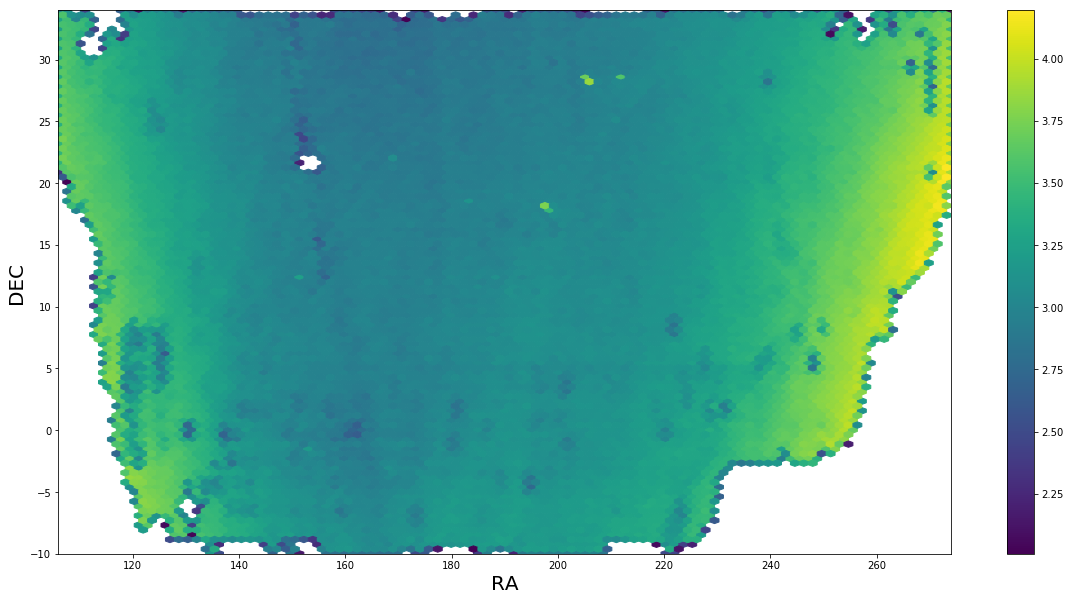

In [111]:
# Make the Sky distribution plot
plt.figure(figsize=(20,10))

ramin=np.min(sampl.ra)
ramax=np.max(sampl.ra)
decmin=np.min(sampl.dec)
decmax=np.max(sampl.dec)

plt.hexbin(df.ra,df.dec,bins='log', cmap=plt.cm.viridis,
           mincnt=100, extent=(ramin, ramax, decmin, decmax),gridsize=100)
plt.xlabel('RA',fontsize=20)
plt.ylabel('DEC',fontsize=20)
plt.axis([ramin, ramax, decmin, decmax])
plt.colorbar()
plt.show()

# area=(xmax-xmin)*(ymax-ymin)*np.cos(3.14159*np.median(df.dec)/180.0)
# print("Approximate area = ",area," deg2")

## Initial Selection of sources in the region

We now subselect point sources with low proper motion and parallax from the list of extracted sources. We use the following criteria:

- Legacy Survey DR5 TYPE = 'PSF' (already done in earlier selection)
- Total Proper Motion (defined as sqrt(PMRA^2+PMDEC^2)) consistent with zero at 2sigma (PM/err(PM))<= 2.0
- Total Proper Motion Error (defined as sqrt(PMRA_ERROR^2+PMDEC_ERROR^2)) <= 2.0 mas/yr
- Parallax consistent with zero: PARALLAX/PARALLAX_ERROR <= 2 mas OR PARALLAX <= 1 mas
- Gaia Astrometric Excess Noise <= 0.3G - 5.3

The last criterion on the Gaia astrometric excess noise is in order to exclude any galaxies or inadequately deblended stars.

In [107]:
# Now apply the selection for just the distant objects
pmra=df.pmra
pmdec=df.pmdec
pmra_err=df.pmra_error
pmdec_err=df.pmdec_error
par=df.parallax
par_err=df.parallax_error
ae=df.astrometric_excess_noise
gaia_g=df.gaia_g
morp=df.type

pm=np.sqrt(pmra**2+pmdec**2)
pmerr=np.sqrt(pmra_err**2+pmdec_err**2)

#isamp = (pm<=3.0)&(pmerr<=2.0)&((np.abs(par/par_err)<=2.0)|(par<=1.0))&(ae<=(0.3*gaia_g-5.3))&(morp=='PSF ')
isamp = ((pm<=0.4)|(pm/pmerr<=2.0))&(pmerr<=2.0)&\
    ((np.abs(par/par_err)<=2.0)|(par<=1.0))&(ae<=(0.3*gaia_g-5.3))&(morp=='PSF ')

sampl=df[isamp]
print("Sample size = ",len(sampl),"; Percent of total = ",(100*len(sampl)/float(len(pmra))),"%")

Sample size =  741451 ; Percent of total =  3.7839683360692153 %


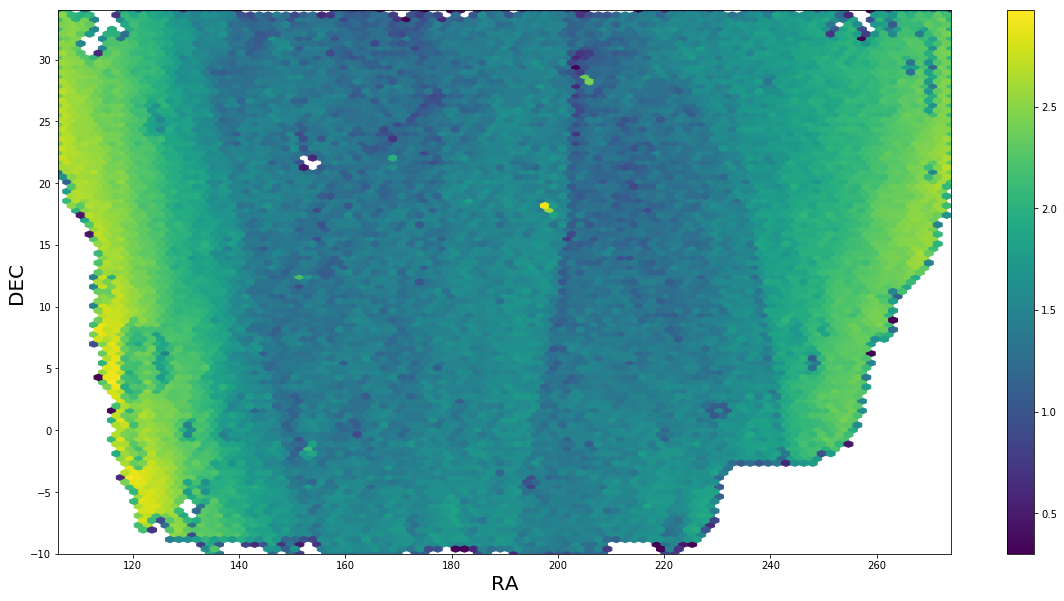

In [110]:
# Make the Sky distribution plot
plt.figure(figsize=(20,10))

plt.hexbin(sampl.ra,sampl.dec,bins='log', cmap=plt.cm.viridis,
           mincnt=1, extent=(ramin, ramax, decmin, decmax),gridsize=100)
plt.xlabel('RA',fontsize=20)
plt.ylabel('DEC',fontsize=20)
plt.axis([ramin, ramax, decmin, decmax])
plt.colorbar()
plt.show()

# Separating Stars and QSOs

[-0.5, 2.6, -0.5, 2]

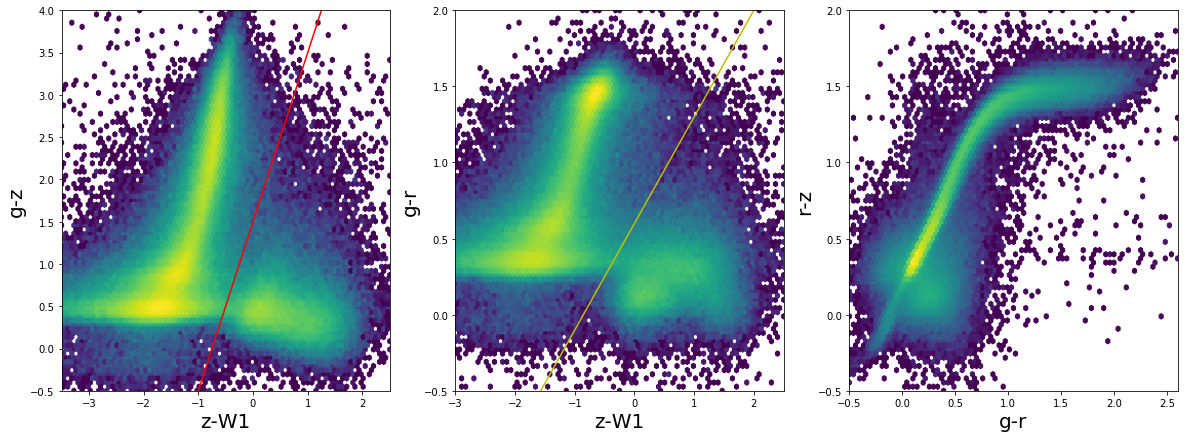

In [112]:
# Make color-color plots for the sample
fig, axs = plt.subplots(1,3,figsize=(20,7))

# g-z vs r-w1 
xmin = -3.5
xmax = 2.5
ymin = -0.5
ymax = 4
ax=axs[0]
im1 = ax.hexbin((sampl.z_w1),(sampl.g_r+sampl.r_z), bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('z-W1',fontsize=20)
ax.set_ylabel("g-z",fontsize=20)
ax.axis([xmin, xmax, ymin, ymax])
xx=np.arange(10)-3
yy=2.0*xx+1.5
ax.plot(xx,yy,'r-')


# g-r vs z-W1
xmin = -3
xmax = 2.5
ymin = -0.5
ymax = 2

ax=axs[1]
im1 = ax.hexbin(sampl.z_w1,sampl.g_r, bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('z-W1',fontsize=20)
ax.set_ylabel("g-r",fontsize=20)
ax.axis([xmin, xmax, ymin, ymax])
yy=0.7*xx+0.6
ax.plot(xx,yy,'y-')

# g-r vs r-z 
xmin = -0.5
xmax = 2.6
ymin = -0.5
ymax = 2
ax=axs[2]
im1 = ax.hexbin(sampl.r_z,sampl.g_r, bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('g-r',fontsize=20)
ax.set_ylabel('r-z',fontsize=20)
ax.axis([xmin, xmax, ymin, ymax])

In [113]:
# Apply the star - QSO separation selection to the sample: 
#   If W1 has SNR > 2, then g-z >= 2(z-W1)+1.5; else select all SNR(W1) < 2.0 objects

gz = sampl.g_r+sampl.r_z
zw1 = sampl.z_w1
rw1 = sampl.r_z+sampl.z_w1
snrlim = 2.0   # s/n limit for W1
#istar = ((sampl.snr_w1 >= snrlim)&((gz>=2.0*zw1+1.5)|(gz>=0.7*zw1+0.6))) | (sampl.snr_w1 < snrlim)
istar = ((sampl.snr_w1 >= snrlim)&(gz>=2.0*zw1+1.5)) | (sampl.snr_w1 < snrlim)
star = sampl[istar]
qso = sampl[np.logical_not(istar)]
print("Total number of objects in sample = ",len(sampl))
print("Number of objects selected as stars = ",len(star))
print("Number of objects selected as QSOs = ",len(qso))


badw1 =  (sampl.snr_w1 < snrlim)
print("Number of objects with < 2-sigma W1 measurements",len(sampl[badw1]))

Total number of objects in sample =  741451
Number of objects selected as stars =  394435
Number of objects selected as QSOs =  347016
Number of objects with < 2-sigma W1 measurements 94715


[-0.5, 2.6, -0.5, 2]

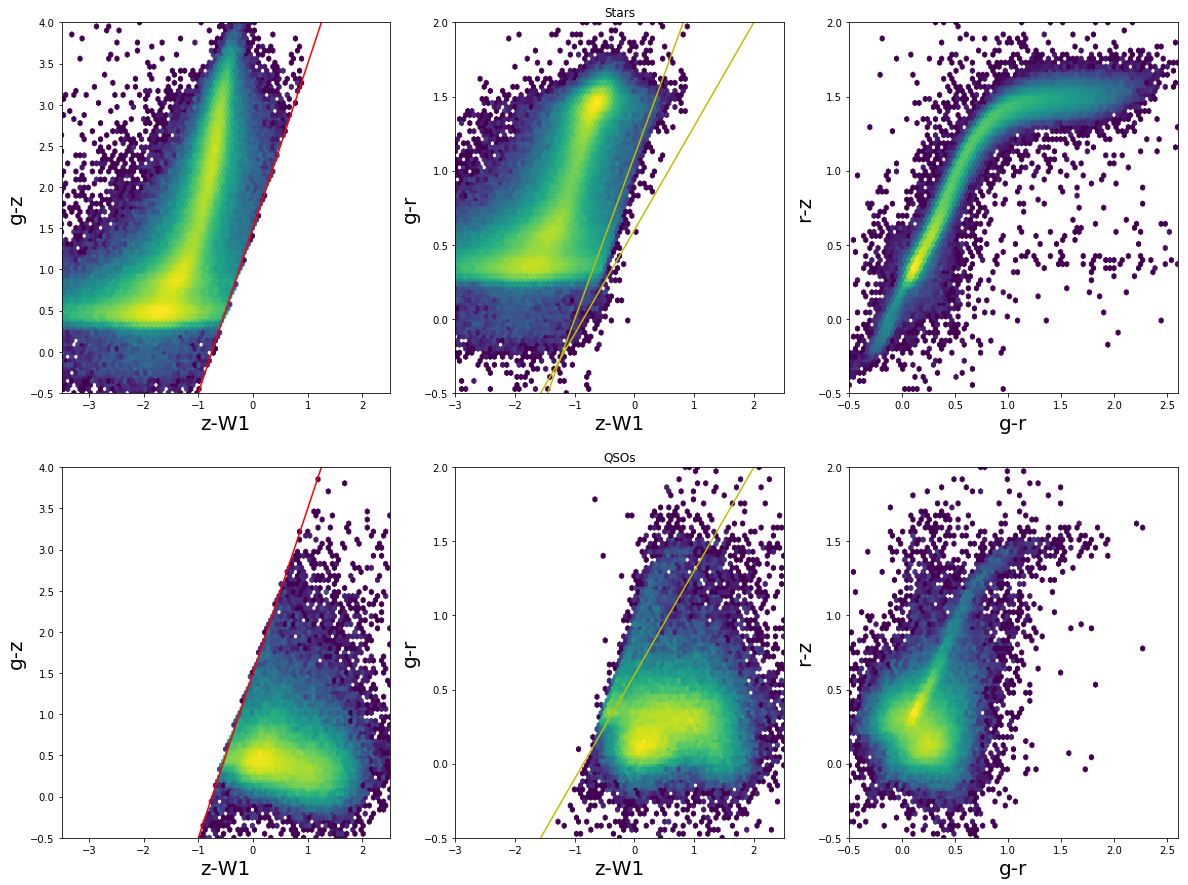

In [63]:
# Make color-color plots for the Stars
fig, axs = plt.subplots(2,3,figsize=(20,15))

#------------
# QSOs
#------------

# g-z vs r-w1 
xmin = -3.5
xmax = 2.5
ymin = -0.5
ymax = 4
ax=axs[0,0]
im1 = ax.hexbin((star.z_w1),(star.g_r+star.r_z), bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('z-W1',fontsize=20)
ax.set_ylabel("g-z",fontsize=20)
ax.axis([xmin, xmax, ymin, ymax])
xx=np.arange(10)-3
yy=2.0*xx+1.5
ax.plot(xx,yy,'r-')


# g-r vs z-W1
xmin = -3
xmax = 2.5
ymin = -0.5
ymax = 2

ax=axs[0,1]
im1 = ax.hexbin(star.z_w1,star.g_r, bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('z-W1',fontsize=20)
ax.set_ylabel("g-r",fontsize=20)
ax.set_title("Stars")
ax.axis([xmin, xmax, ymin, ymax])
yy=1.1*xx+1.1
ax.plot(xx,yy,'y-')
yy=0.7*xx+0.6
ax.plot(xx,yy,'y-')

# g-r vs r-z 
xmin = -0.5
xmax = 2.6
ymin = -0.5
ymax = 2
ax=axs[0,2]
im1 = ax.hexbin(star.r_z,star.g_r, bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('g-r',fontsize=20)
ax.set_ylabel('r-z',fontsize=20)
ax.axis([xmin, xmax, ymin, ymax])

#------------
# QSOs
#------------

# g-z vs r-w1 
xmin = -3.5
xmax = 2.5
ymin = -0.5
ymax = 4
ax=axs[1,0]
im1 = ax.hexbin((qso.z_w1),(qso.g_r+qso.r_z), bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('z-W1',fontsize=20)
ax.set_ylabel("g-z",fontsize=20)
ax.axis([xmin, xmax, ymin, ymax])
xx=np.arange(10)-3
yy=2.0*xx+1.5
ax.plot(xx,yy,'r-')

# g-r vs z-W1
xmin = -3
xmax = 2.5
ymin = -0.5
ymax = 2

ax=axs[1,1]
im1 = ax.hexbin(qso.z_w1,qso.g_r, bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('z-W1',fontsize=20)
ax.set_ylabel("g-r",fontsize=20)
ax.set_title("QSOs")
ax.axis([xmin, xmax, ymin, ymax])
yy=0.7*xx+0.6
ax.plot(xx,yy,'y-')

# g-r vs r-z 
xmin = -0.5
xmax = 2.6
ymin = -0.5
ymax = 2
ax=axs[1,2]
im1 = ax.hexbin(qso.r_z,qso.g_r, bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('g-r',fontsize=20)
ax.set_ylabel('r-z',fontsize=20)
ax.axis([xmin, xmax, ymin, ymax])


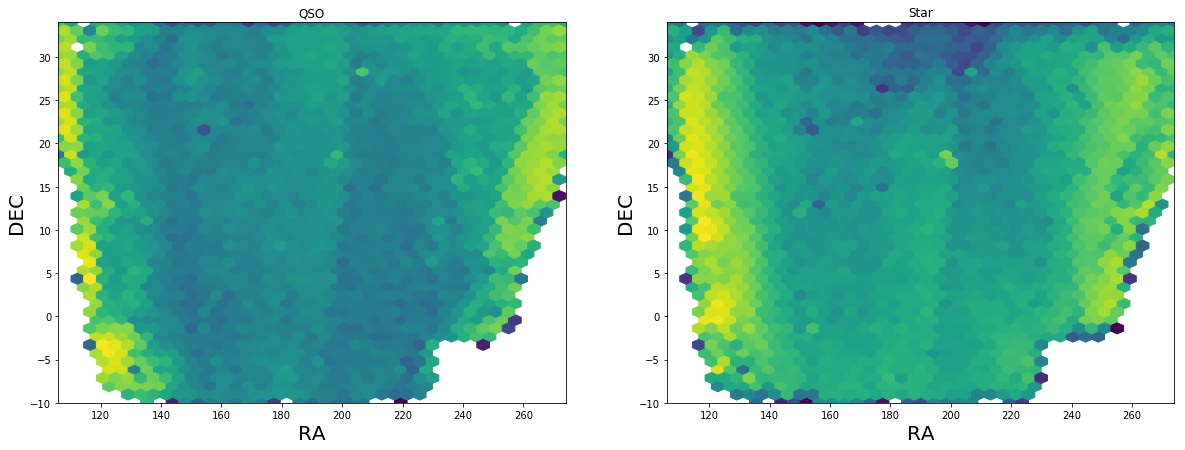

In [114]:
# Plot the sky distribution of QSOs and Stars separately
fig, axs = plt.subplots(1,2,figsize=(20,7))

ax=axs[0]
im1=ax.hexbin(qso.ra,qso.dec,bins='log',cmap=plt.cm.viridis,
           mincnt=1, extent=(ramin, ramax, decmin, decmax),gridsize=40)
ax.set_xlabel('RA',fontsize=20)
ax.set_ylabel("DEC",fontsize=20)
ax.axis([ramin, ramax, decmin, decmax])
ax.set_title("QSO")

ax=axs[1]
im1=ax.hexbin(star.ra,star.dec,bins='log',cmap=plt.cm.viridis,
           mincnt=1, extent=(ramin, ramax, decmin, decmax),gridsize=40)
ax.set_xlabel('RA',fontsize=20)
ax.set_ylabel("DEC",fontsize=20)
ax.axis([ramin, ramax, decmin, decmax])
ax.set_title("Star")

#plt.colorbar()
#plt.show()

In [132]:
# Read in the catalog of known dwarf galaxies and convert to a Pandas frame
dg=pd.read_csv('NGC_LS5_dwarfs.csv',na_values=('Infinity','-Infinity'))
print ("Number of columns in the file:", len(dg))
n = len(dg)
dg.columns
dg.head()

Number of columns in the file: 19


NAME          RA        DEC    D  MTYPE    R1  VMAG
0       Segue (I)  151.766667  16.081944  0.0   dSph   4.4  15.3
1       Bootes II  209.500000  12.850000  0.0   dSph   4.2  15.4
2  Coma Berenices  186.745833  23.904167  0.0   dSph   6.0  14.1
3      Bootes III  209.300000  26.800000  0.0  dSph?   NaN  12.6
4      Bootes (I)  210.025000  14.500000  0.0   dSph  12.6  12.8

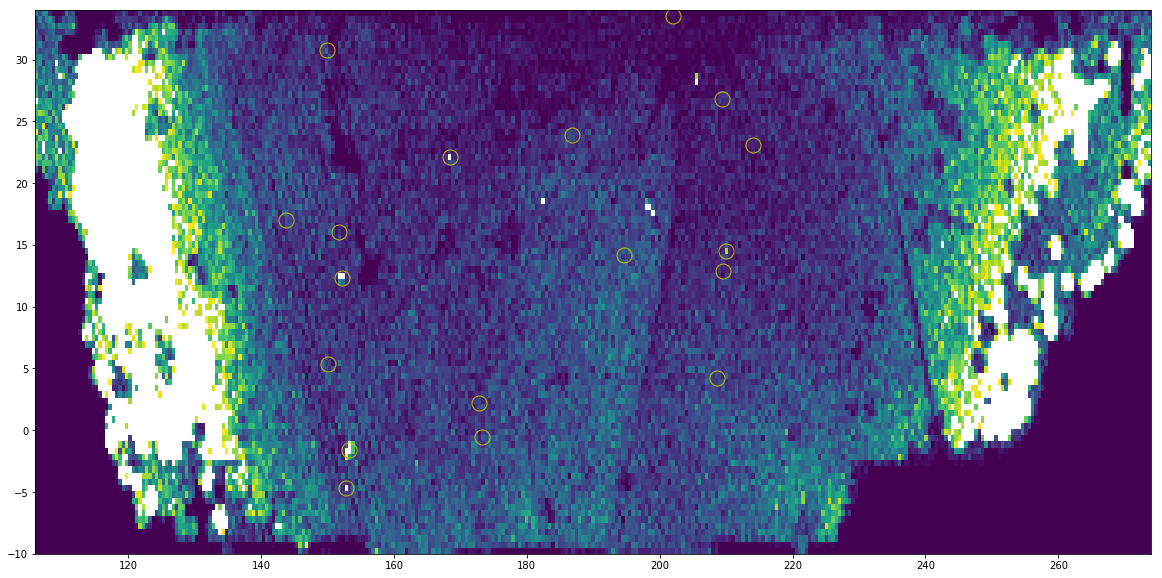

In [151]:
# Make a plot of the sky distribution and overlay the locations of the known dwarf galaxies
bsize=0.5
nx=np.int((ramax-ramin)/bsize)
ny=int((decmax-decmin)/bsize)
nbins=[nx,ny]
plt.figure(figsize=(20,10))
ims=plt.hist2d(star.ra,star.dec,bins=nbins,cmin=0,cmax=35)
plt.plot(dg.RA,dg.DEC,'yo',markersize=15,markerfacecolor='none')

Some of the brighter regions in the colormap are identified with known dwarfs, but there are some regions with bright pixels which are not in Alan McConnachie's 2012 compilation. Let's investigate further

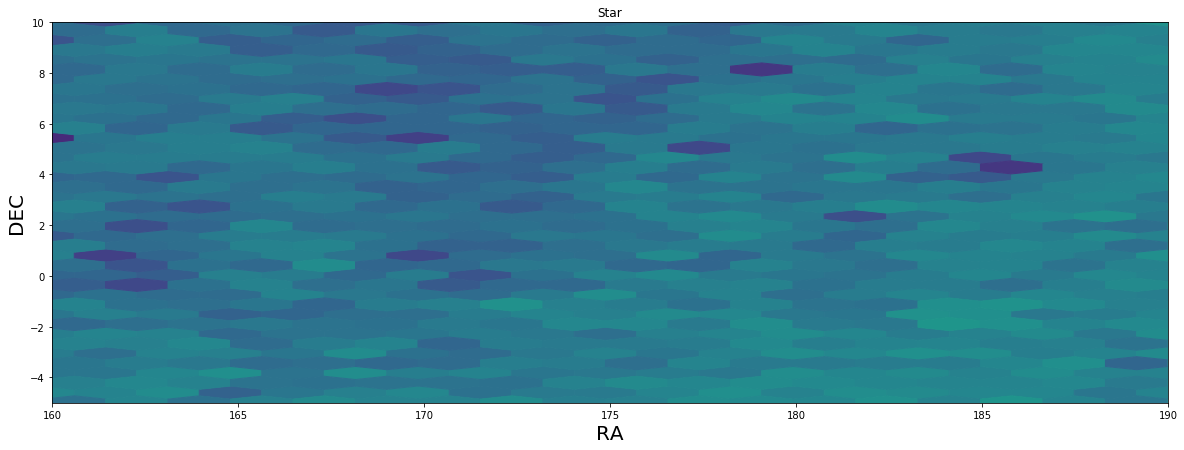

In [162]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
xmin = 160
xmax = 190
ymin = -5
ymax = 10
im1=ax.hexbin(star.ra,star.dec,bins='log',cmap=plt.cm.viridis,
           mincnt=1, extent=(ramin, ramax, decmin, decmax),gridsize=100)
ax.set_xlabel('RA',fontsize=20)
ax.set_ylabel("DEC",fontsize=20)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("Star")



/data0/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/data0/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


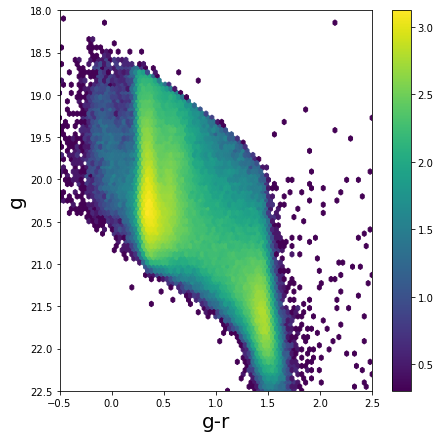

In [116]:
# g-r vs g
plt.figure(figsize=(7,7))
xmin = -0.5
xmax = 2.5
ymin = 22.5
ymax = 18.0
gmag = -2.5*np.log10(star.flux_g)+22.5
plt.hexbin((star.g_r),(gmag), bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
plt.xlabel('g-r',fontsize=20)
plt.ylabel("g",fontsize=20)
plt.axis([xmin, xmax, ymin, ymax])
plt.colorbar()
plt.show()


Median QSO 'proper motion' =  -357.169770237 -357.62834684  microarcsec/year


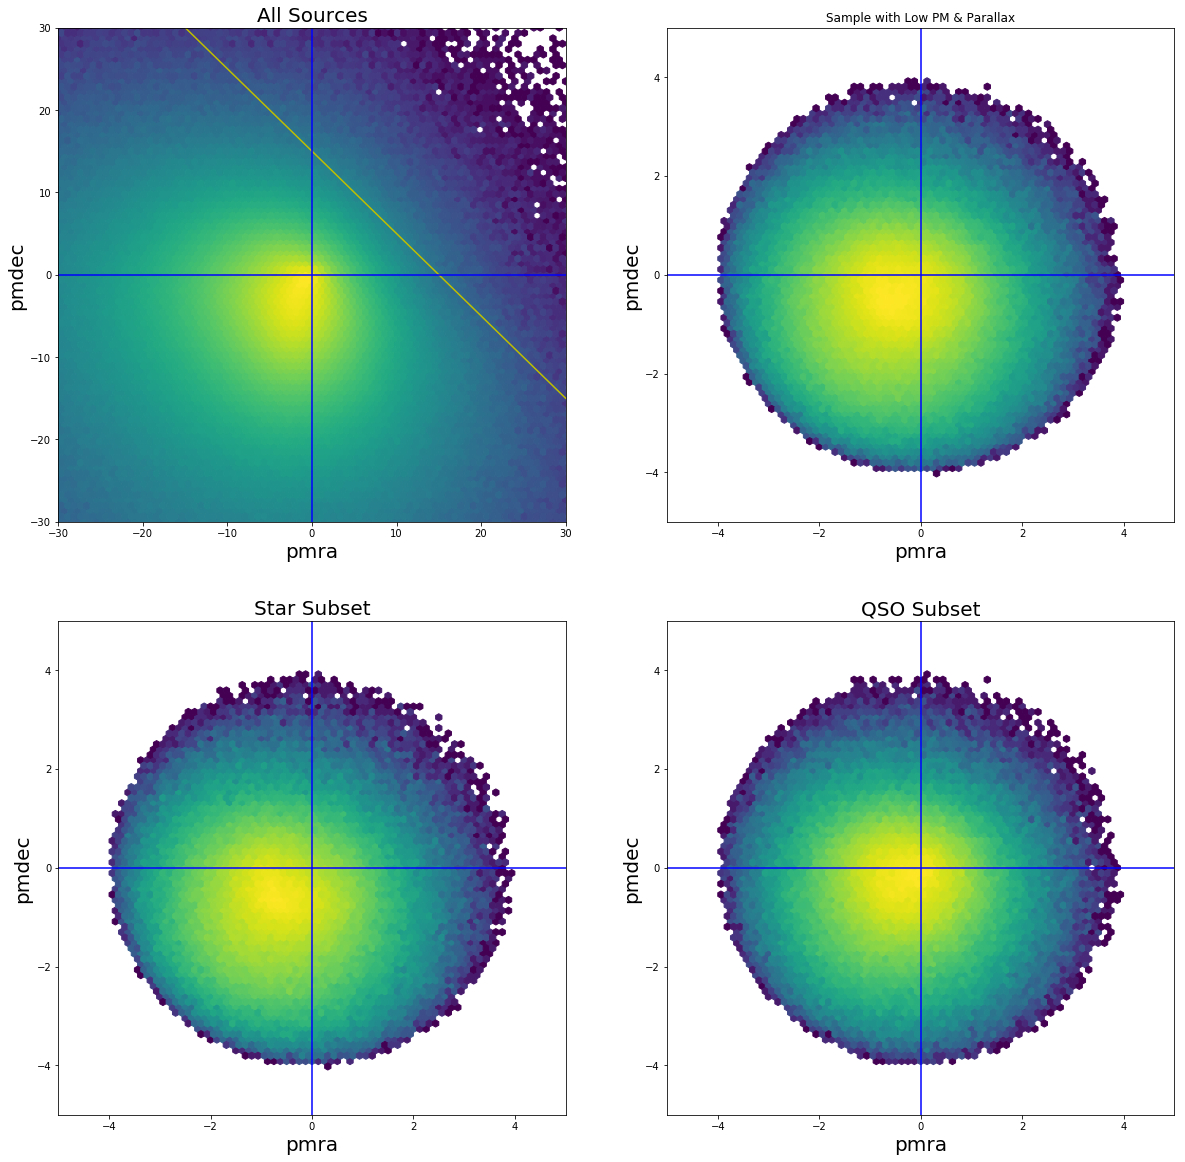

In [117]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# keep = (result_join.type == 'PSF ')


# PM distribution of all objects in the region
xmin = -30
xmax = 30
ymin = -30
ymax = 30
ax=axs[0,0]

im1 = ax.hexbin(df.pmra,df.pmdec, bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('pmra',fontsize=20)
ax.set_ylabel("pmdec",fontsize=20)
ax.axis([xmin, xmax, ymin, ymax])
xx=[-30,30]
yy=[45,-15]
ax.plot(xx,yy,'y-')
ax.set_title("All Sources",fontsize=20)
ax.plot([-30,30],[0,0],'b-')
ax.plot([0,0],[-30,30],'b-')
plt.colorbar


# PM distribution of sample
xmin = -5
xmax = 5
ymin = -5
ymax = 5

ax=axs[0,1]
im1 = ax.hexbin(sampl.pmra,sampl.pmdec, bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('pmra',fontsize=20)
ax.set_ylabel("pmdec",fontsize=20)
ax.set_title("Sample with Low PM & Parallax")
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([-30,30],[0,0],'b-')
ax.plot([0,0],[-30,30],'b-')


# PM distribution of stars
ax=axs[1,0]
im1 = ax.hexbin(star.pmra,star.pmdec, bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('pmra',fontsize=20)
ax.set_ylabel("pmdec",fontsize=20)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("Star Subset",fontsize=20)
ax.plot([-30,30],[0,0],'b-')
ax.plot([0,0],[-30,30],'b-')


# PM distribution of QSOs
ax=axs[1,1]
im1 = ax.hexbin(qso.pmra,qso.pmdec, bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
ax.set_xlabel('pmra',fontsize=20)
ax.set_ylabel("pmdec",fontsize=20)
ax.set_title("QSO Subset")
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("QSO Subset",fontsize=20)
ax.plot([-30,30],[0,0],'b-')
ax.plot([0,0],[-30,30],'b-')


print("Median QSO 'proper motion' = ",np.median(qso.pmra)*1000.,np.median(qso.pmdec)*1000.," microarcsec/year")
#plt.show()

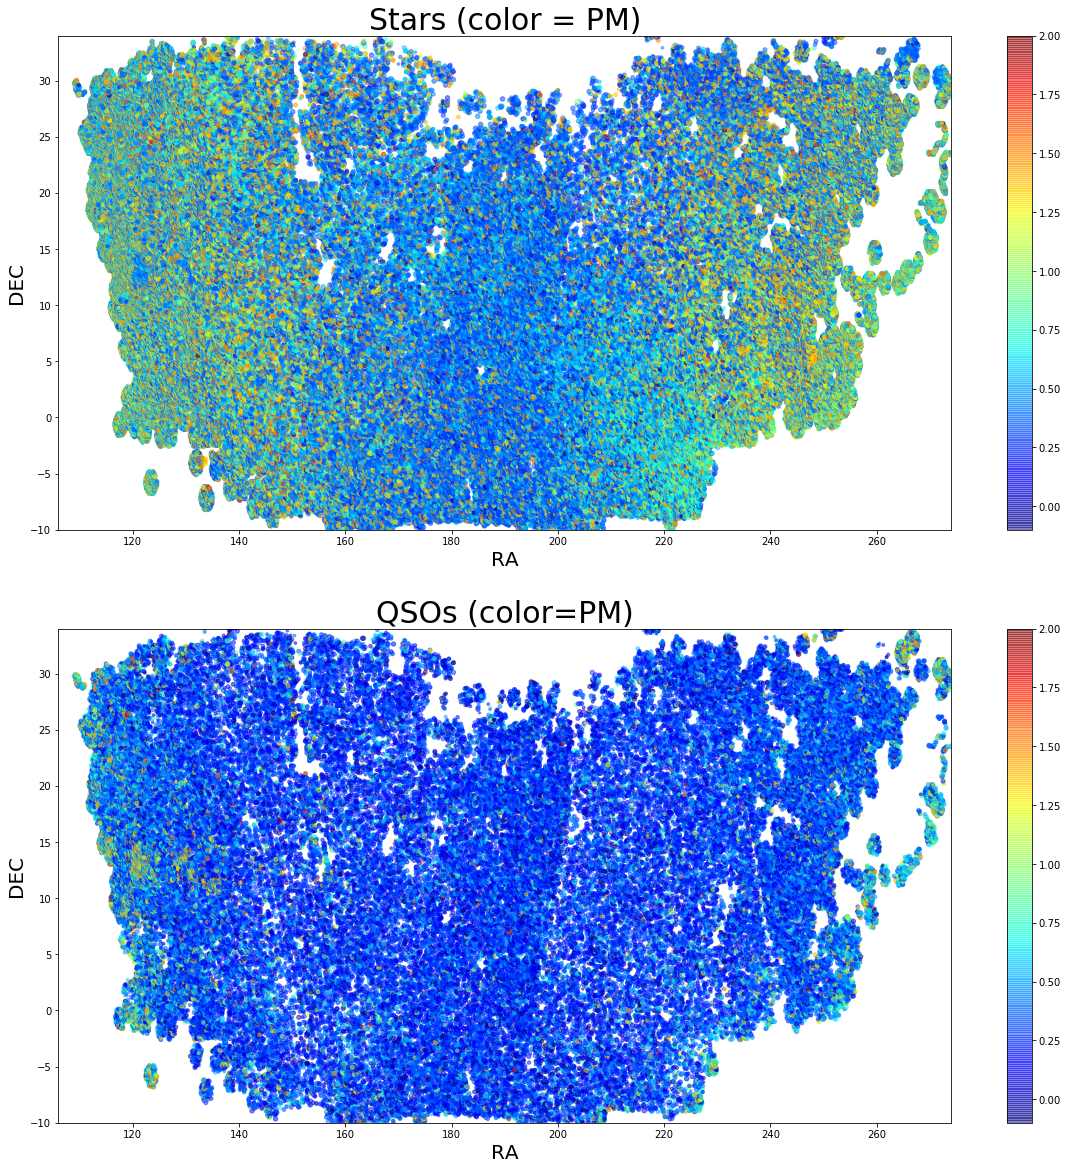

In [119]:
# Plot sky distribution of the Stars and QSOs, color-coding by total proper motion
# Note that this sample has already been chosen to only have objects with PMs consistent with zero at the 2-sigma level

fig, axs = plt.subplots(2,1,figsize=(20,20))

xmin=np.min(star.ra)
xmax=np.max(star.ra)
ymin=np.min(star.dec)
ymax=np.max(star.dec)
plt.subplot(211)
#plt.hexbin(star.ra,star.dec,cmap=plt.cm.viridis,
#          mincnt=10, extent=(xmin, xmax, ymin, ymax),gridsize=40)
sz=10*np.sqrt(star.pmra_error**2+star.pmdec_error**2)
plt.scatter(star.ra,star.dec,c=star.g_r,s=sz,vmin=-0.1,vmax=2.0,cmap='jet',alpha=0.5)
plt.xlabel('RA',fontsize=20)
plt.ylabel('DEC',fontsize=20)
plt.title('Stars (color = PM)',fontsize=30)
plt.axis([xmin, xmax, ymin, ymax])
plt.colorbar()

plt.subplot(212)
# plt.hexbin(qso.ra,qso.dec,cmap=plt.cm.viridis,
  #         mincnt=50, extent=(xmin, xmax, ymin, ymax),gridsize=40)
sz=10*np.sqrt(qso.pmra_error**2+qso.pmdec_error**2)
plt.scatter(qso.ra,qso.dec,c=qso.g_r,s=sz,vmin=-0.1,vmax=2.0,cmap='jet',alpha=0.5)
plt.xlabel('RA',fontsize=20)
plt.ylabel('DEC',fontsize=20)
plt.title('QSOs (color=PM)',fontsize=30)
plt.axis([xmin, xmax, ymin, ymax])
plt.colorbar()

plt.show()

In the parent sample, the PMRA-PMDEC distribution shows the following features: (1) the bulk of sources are distributed with proper motions with a mean motion to the south-west; (2) there is a clump of sources centered near [0,0]; (3) the region with proper motions to the NE is mostly devoid of sources. The sources near [0,0] are mostly sources that match the QSO selection criterion; the ones that are not, are the ones we are most interested in. 

First, however, we investigate the sources with motions away from the bulk of the stars.

All the sources with "weird" proper motions (i.e., in the top right of the PMRA-PMDEC distribution) appear to be red stars. These are probably just field M dwarfs that are close to the sun, and we can drop these from our sample.

## Selecting the Subset of Blue Stars

We now subselect the sources from the "stars" subset that are blue. This is the final set of targets that are faint (>18.5), blue (g-r<0.5, r-z<0.5), low proper-motion stars (consistent with PM~0).

In [192]:
# Apply final color selection
grmin=0.25
rzmin=0.25
i=(star.g_r <= grmin)&(star.r_z <= rzmin)
bstar=star[i]

area=(ramax-ramin)*(decmax-decmin)*np.cos(3.14159*np.median(df.dec)/180.0) # totally wrong for a huge area
print("Number of blue stars matching color criterion = ",len(bstar))
print("Density of targets on the sky in this region = ",(len(bstar)/area)," per sq. deg.")
print("Median proper motion of all stars in sample = [",np.median(star.pmra),",",np.median(star.pmdec),"] mas/yr")
print("Median proper motion of blue stars in sample = [",np.median(bstar.pmra),",",np.median(bstar.pmdec),"] mas/yr")

Number of blue stars matching color criterion =  8596
Density of targets on the sky in this region =  1.19993405677  per sq. deg.
Median proper motion of all stars in sample = [ -0.630423801524 , -0.68561898356 ] mas/yr
Median proper motion of blue stars in sample = [ -0.65388738385 , -0.915853564288 ] mas/yr


Compare the results with the known RR Lyrae stars selected from the PanSTARRS1 Survey (Sesar et al. 2017, AJ, 153, 204)

Number of columns in the file: 25141
Magnitude range for the RR Lyraes: 10.57 20.86
(g-r) color range for the RR Lyraes: -0.37 0.21
Number of RR Lyrae with magnitudes g > 18:  15785


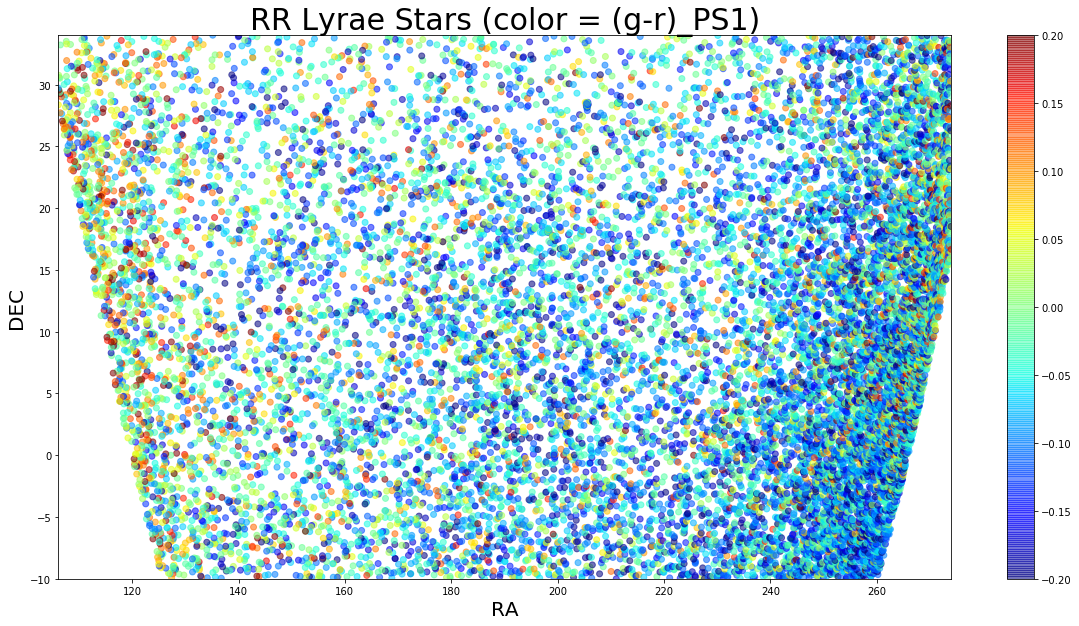

In [209]:
# Read in the list of PS1 RR Lyrae stars in the region (subset in NGC_PS1_RRLyrae.csv)
# Read in the catalog of known dwarf galaxies and convert to a Pandas frame
# and get some simple statistics

rr=pd.read_csv('NGC_PS1_RRLyrae.csv',na_values=('Infinity','-Infinity'))
print ("Number of columns in the file:", len(rr))
print ("Magnitude range for the RR Lyraes:",np.min(rr.GMAG),np.max(rr.GMAG))
rrgr=rr.GMAG-rr.RMAG
print ("(g-r) color range for the RR Lyraes:",np.min(rrgr),np.max(rrgr))
ifaint = rr.GMAG <=18
print ("Number of RR Lyrae with magnitudes g > 18: ",len(rr[ifaint].GMAG))
n = len(rr)
rr.columns
rr.head()

# plot up the sky distribution of the faint (g>18) RR Lyrae
fig, axs = plt.subplots(1,1,figsize=(20,10))

xmin=np.min(rr.RAJ2000)
xmax=np.max(rr.RAJ2000)
ymin=np.min(rr.DEJ2000)
ymax=np.max(rr.DEJ2000)
plt.subplot(111)
#plt.hexbin(rr.RAJ2000,rr.DEJ2000,cmap=plt.cm.viridis,
#          mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=30)
plt.scatter(rr[ifaint].RAJ2000,rr[ifaint].DEJ2000,c=rrgr[ifaint],vmin=-0.2,vmax=0.2,cmap='jet',alpha=0.55)
plt.xlabel('RA',fontsize=20)
plt.ylabel('DEC',fontsize=20)
plt.title('RR Lyrae Stars (color = (g-r)_PS1)',fontsize=30)
plt.axis([xmin, xmax, ymin, ymax])
plt.colorbar()

In [226]:
# Cross correlate all the sample stars with the RR Lyrae list
idxall,distall = crossmatch.xmatch(star.ra,star.dec,rr.RAJ2000,rr.DEJ2000)

maxdist = (2./3600.) # Maximum matching distance between the two catalogs
ikall = distall.value <= maxdist

print ("Total number of stars in sample : ",len(star.ra))
print ("Number of sample star - RR Lyrae matches : ",len(idxall[ikall]))

# Make histograms of the stars that are matchedck and 

Total number of stars in sample :  394435
Number of sample star - RR Lyrae matches :  1218


In [227]:
# Cross correlate the blue stars with the RR Lyrae list
idx,dist = crossmatch.xmatch(bstar.ra,bstar.dec,rr.RAJ2000,rr.DEJ2000)
idx2,dist2 = crossmatch.xmatch(rr.RAJ2000,rr.DEJ2000,bstar.ra,bstar.dec)

maxdist = (2./3600.) # Maximum matching distance between the two catalogs

ik = dist.value <= maxdist
ik2 = dist2.value <= maxdist

print ("Number of blue stars in sample : ",len(bstar.ra))
print ("Number of RR Lyrae stars in sample : ",len(rr.RAJ2000))
print ("Number of blue star - RR Lyrae matches : ",len(idx[ik]))
print ("Number of RR Lyrae - blue star matches : ",len(idx2[ik2]))
#print,np.min(dist),np.max(dist)

Number of blue stars in sample :  8596
Number of RR Lyrae stars in sample :  25141
Number of blue star - RR Lyrae matches :  513
Number of RR Lyrae - blue star matches :  514


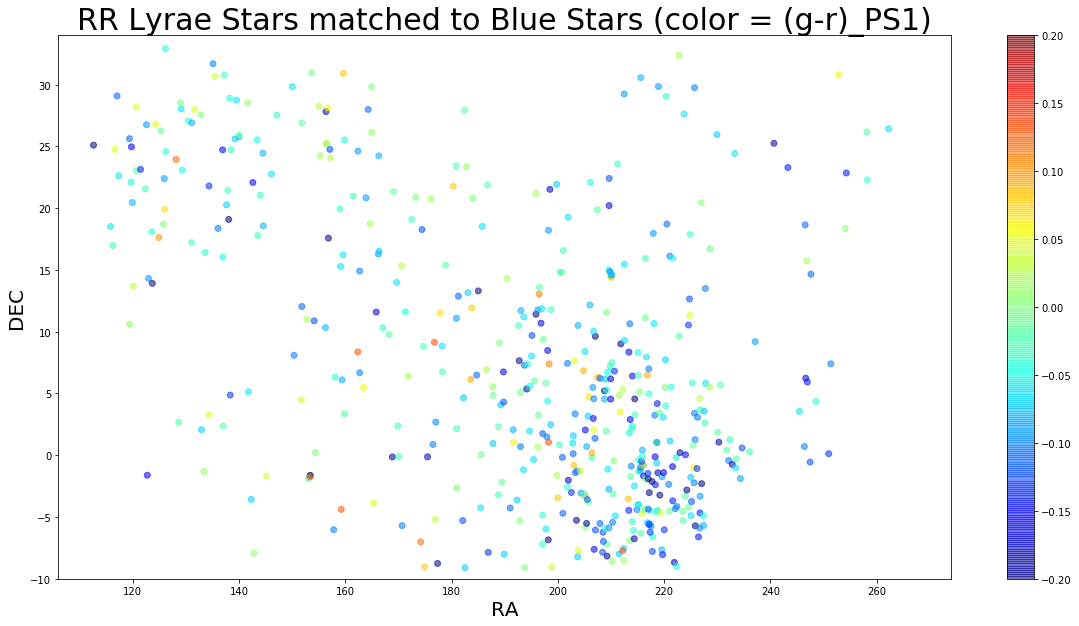

In [224]:
# Look at the sky distribution of the matched sources
# plot up the sky distribution of the faint (g>18) RR Lyrae
fig, axs = plt.subplots(1,1,figsize=(20,10))

xmin=np.min(star.ra)
xmax=np.max(star.ra)
ymin=np.min(star.dec)
ymax=np.max(star.dec)
plt.subplot(111)
#plt.hexbin(rr.RAJ2000,rr.DEJ2000,cmap=plt.cm.viridis,
#          mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=30)
x=rr.RAJ2000[idx[ik]]
y=rr.DEJ2000[idx[ik]]
c=(rr.GMAG-rr.RMAG)[idx[ik]]
plt.scatter(x,y,c=c,vmin=-0.2,vmax=0.2,cmap='jet',alpha=0.55)
plt.xlabel('RA',fontsize=20)
plt.ylabel('DEC',fontsize=20)
plt.title('RR Lyrae Stars matched to Blue Stars (color = (g-r)_PS1)',fontsize=30)
plt.axis([xmin, xmax, ymin, ymax])
plt.colorbar()

### Plot Results

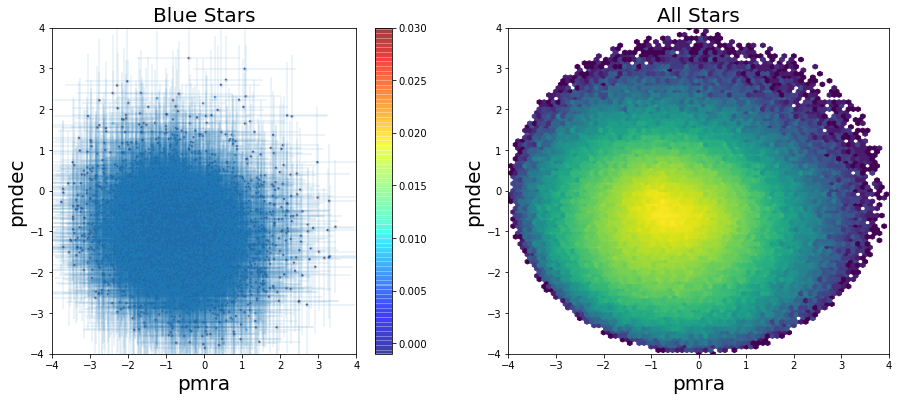

In [126]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))


# PM distribution for blue stars
plt.subplot(121)
xmin=-4
xmax=4
ymin=-4
ymax=4
sz=np.sqrt(bstar.pmra_error**2+bstar.pmdec_error**2)
plt.errorbar(bstar.pmra,bstar.pmdec,bstar.pmra_error,bstar.pmdec_error,marker='.',ls='None',alpha=0.1)
plt.scatter(bstar.pmra,bstar.pmdec,c=bstar.g_r,s=sz,vmin=-0.001,vmax=0.03,cmap='jet',alpha=0.5)
plt.xlabel('pmra',fontsize=20)
plt.ylabel("pmdec",fontsize=20)
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Blue Stars",fontsize=20)
plt.colorbar()

# PM distribution for all stars
plt.subplot(122)
im1 = plt.hexbin(star.pmra,star.pmdec, bins='log',cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin, xmax, ymin, ymax),gridsize=80)
plt.xlabel('pmra',fontsize=20)
plt.ylabel("pmdec",fontsize=20)
plt.axis([xmin, xmax, ymin, ymax])
plt.title("All Stars",fontsize=20) 

plt.show()


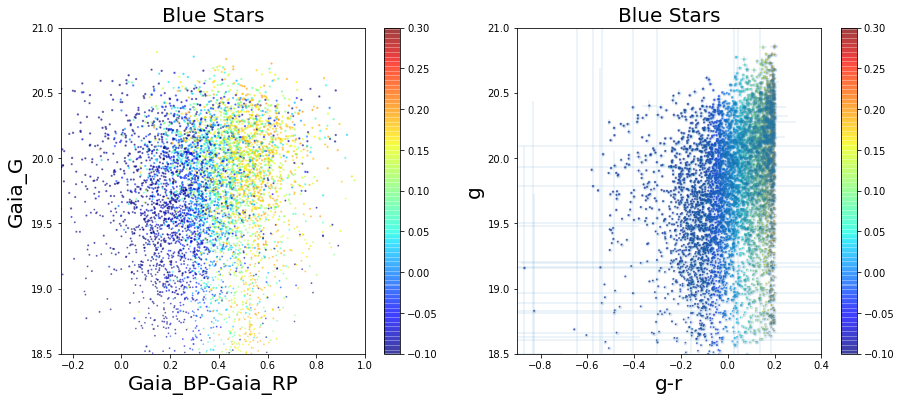

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Gaia Color-Magnitude distribution for blue stars
plt.subplot(121)
xmin=-0.25
xmax=1.0
ymin=18.5
ymax=21.0
# plt.errorbar(bstar.pmra,bstar.pmdec,bstar.pmra_error,bstar.pmdec_error,marker='.',ls='None',alpha=0.1)
plt.scatter(bstar.bp_rp,bstar.gaia_g,c=bstar.g_r,s=sz,vmin=-0.1,vmax=0.3,cmap='jet',alpha=0.5)
plt.xlabel('Gaia_BP-Gaia_RP',fontsize=20)
plt.ylabel("Gaia_G",fontsize=20)
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Blue Stars",fontsize=20)
plt.colorbar()

# Legacy Survey Color-Magnitude distribution for blue stars
plt.subplot(122)
xmin=-0.9
xmax=0.4
ymin=18.5
ymax=21.0
g=(-2.5*np.log10(bstar.flux_g)+22.5)
gerr=(1.086/np.sqrt(bstar.flux_ivar_g)/bstar.flux_g)
rerr=(1.086/np.sqrt(bstar.flux_ivar_r)/bstar.flux_r)
grerr=np.sqrt(gerr**2+rerr**2)
plt.errorbar(bstar.g_r,g,grerr,gerr,marker='.',ls='None',alpha=0.1)
plt.scatter(bstar.g_r,(-2.5*np.log10(bstar.flux_g)+22.5),c=bstar.g_r,s=sz,vmin=-0.1,vmax=0.3,cmap='jet',alpha=0.5)
plt.xlabel('g-r',fontsize=20)
plt.ylabel("g",fontsize=20)
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Blue Stars",fontsize=20)
plt.colorbar()


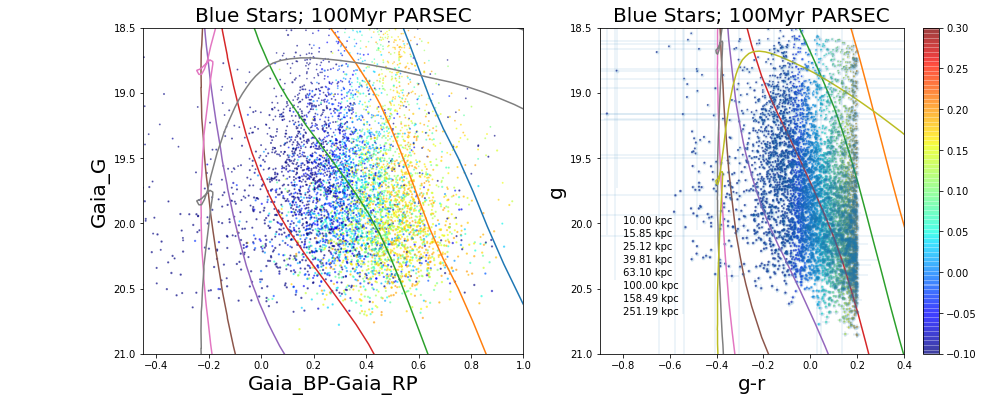

In [128]:

# Gaia Color-Magnitude distribution for blue stars
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
plt.subplot(121)
xmin=-0.45
xmax=1.0
ymin=21.0
ymax=18.5
plt.scatter(bstar.bp_rp,bstar.gaia_g,c=bstar.g_r,s=sz,vmin=-0.1,vmax=0.3,cmap='jet',alpha=0.5)
plt.xlabel('Gaia_BP-Gaia_RP',fontsize=20)
plt.ylabel("Gaia_G",fontsize=20)
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Blue Stars; 100Myr PARSEC",fontsize=20)
# Overplot the isochrones
f=np.loadtxt("parsec_solar_100Myr_Gaia.dat",comments='#',dtype=float)
Ggi=f[:,8]
Gbpi=f[:,9]
Grpi=f[:,10]
Gbp_rp=Gbpi-Grpi
for dm in range(15,23):
    plt.plot(Gbp_rp,(Ggi+dm),'-')
    dist=10.**(1+dm/5.)/1000.
    plt.annotate('{:3.2f} kpc'.format(dist),xy=(-0.8,(20+0.1*(dm-15))))

# Legacy Survey Color-Magnitude distribution for blue stars
plt.subplot(122)
xmin=-0.9
xmax=0.4
ymin=21.0
ymax=18.5
# g=(-2.5*np.log10(qso.flux_g)+22.5)
# gerr=(1.086/np.sqrt(qso.flux_ivar_g)/qso.flux_g)
# rerr=(1.086/np.sqrt(qso.flux_ivar_r)/qso.flux_r)
# grerr=np.sqrt(gerr**2+rerr**2)
# plt.errorbar(qso.g_r,g,grerr,gerr,marker='.',ls='None',alpha=0.1)
# plt.scatter(qso.g_r,(-2.5*np.log10(qso.flux_g)+22.5),c=qso.g_r,s=sz,vmin=-0.1,vmax=0.3,cmap='jet',alpha=0.5)

g=(-2.5*np.log10(bstar.flux_g)+22.5)
gerr=(1.086/np.sqrt(bstar.flux_ivar_g)/bstar.flux_g)
rerr=(1.086/np.sqrt(bstar.flux_ivar_r)/bstar.flux_r)
grerr=np.sqrt(gerr**2+rerr**2)
plt.errorbar(bstar.g_r,g,grerr,gerr,marker='.',ls='None',alpha=0.1)
plt.scatter(bstar.g_r,(-2.5*np.log10(bstar.flux_g)+22.5),c=bstar.g_r,s=sz,vmin=-0.1,vmax=0.3,cmap='jet',alpha=0.5)
# Overplot the isochrones
f=np.loadtxt("parsec_solar_100Myr_DECam.dat",comments='#',dtype=float)
logLi=f[:,4]
gi=f[:,24]
ri=f[:,25]
gri=f[:,24]-f[:,25]
for dm in range(15,23):
    plt.plot(gri,(gi+dm),'-')
    dist=10.**(1+dm/5.)/1000.
    plt.annotate('{:3.2f} kpc'.format(dist),xy=(-0.8,(20+0.1*(dm-15))))

plt.xlabel('g-r',fontsize=20)
plt.ylabel("g",fontsize=20)
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Blue Stars; 100Myr PARSEC",fontsize=20)
plt.colorbar()


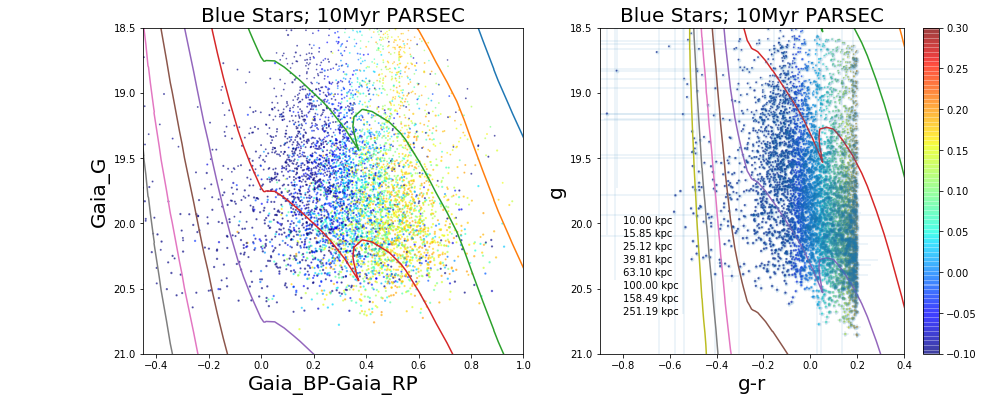

In [129]:

# Gaia Color-Magnitude distribution for blue stars
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
plt.subplot(121)
xmin=-0.45
xmax=1.0
ymin=21.0
ymax=18.5
plt.scatter(bstar.bp_rp,bstar.gaia_g,c=bstar.g_r,s=sz,vmin=-0.1,vmax=0.3,cmap='jet',alpha=0.5)
plt.xlabel('Gaia_BP-Gaia_RP',fontsize=20)
plt.ylabel("Gaia_G",fontsize=20)
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Blue Stars; 10Myr PARSEC",fontsize=20)
# Overplot the isochrones
f=np.loadtxt("parsec_solar_10Myr_Gaia.dat",comments='#',dtype=float)
Ggi=f[:,8]
Gbpi=f[:,9]
Grpi=f[:,10]
Gbp_rp=Gbpi-Grpi
for dm in range(15,23):
    plt.plot(Gbp_rp,(Ggi+dm),'-')
    dist=10.**(1+dm/5.)/1000.
    plt.annotate('{:3.2f} kpc'.format(dist),xy=(-0.8,(20+0.1*(dm-15))))

# Legacy Survey Color-Magnitude distribution for blue stars
plt.subplot(122)
xmin=-0.9
xmax=0.4
ymin=21.0
ymax=18.5
# g=(-2.5*np.log10(qso.flux_g)+22.5)
# gerr=(1.086/np.sqrt(qso.flux_ivar_g)/qso.flux_g)
# rerr=(1.086/np.sqrt(qso.flux_ivar_r)/qso.flux_r)
# grerr=np.sqrt(gerr**2+rerr**2)
# plt.errorbar(qso.g_r,g,grerr,gerr,marker='.',ls='None',alpha=0.1)
# plt.scatter(qso.g_r,(-2.5*np.log10(qso.flux_g)+22.5),c=qso.g_r,s=sz,vmin=-0.1,vmax=0.3,cmap='jet',alpha=0.5)

g=(-2.5*np.log10(bstar.flux_g)+22.5)
gerr=(1.086/np.sqrt(bstar.flux_ivar_g)/bstar.flux_g)
rerr=(1.086/np.sqrt(bstar.flux_ivar_r)/bstar.flux_r)
grerr=np.sqrt(gerr**2+rerr**2)
plt.errorbar(bstar.g_r,g,grerr,gerr,marker='.',ls='None',alpha=0.1)
plt.scatter(bstar.g_r,(-2.5*np.log10(bstar.flux_g)+22.5),c=bstar.g_r,s=sz,vmin=-0.1,vmax=0.3,cmap='jet',alpha=0.5)
# Overplot the isochrones
f=np.loadtxt("parsec_solar_10Myr_DECam.dat",comments='#',dtype=float)
logLi=f[:,4]
gi=f[:,24]
ri=f[:,25]
gri=f[:,24]-f[:,25]
for dm in range(15,23):
    plt.plot(gri,(gi+dm),'-')
    dist=10.**(1+dm/5.)/1000.
    plt.annotate('{:3.2f} kpc'.format(dist),xy=(-0.8,(20+0.1*(dm-15))))

plt.xlabel('g-r',fontsize=20)
plt.ylabel("g",fontsize=20)
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Blue Stars; 10Myr PARSEC",fontsize=20)
plt.colorbar()


In [1167]:
# Try interpolating the 100Myr isochrone

## PM RA & Dec

[106.00100381272, 273.99979483627004, -9.9999807825257303, 33.999644316897395]

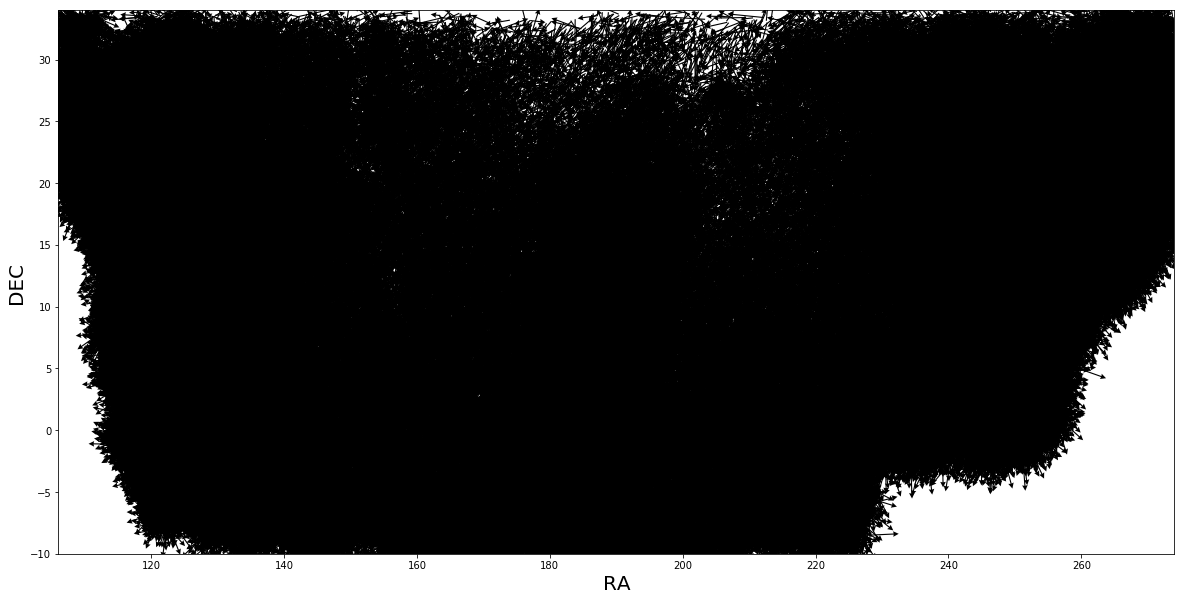

In [120]:
# Plot sky positions of selection
fig, axs = plt.subplots(1,1,figsize=(20,10))

# g-z vs r-w1 (for the star)
xmin = np.min(star.ra)
xmax = np.max(star.ra)
ymin = np.min(star.dec)
ymax = np.max(star.dec)

pm=np.sqrt(star.pmra**2+star.pmdec**2)
theta=np.arctan2(star.pmra,star.pmdec)*180./np.pi
ax=axs
# ax.scatter(star.ra,star.dec,c=pm,s=10,vmin=0,vmax=5,cmap='jet',alpha=0.5)
q = ax.quiver(star.ra,star.dec,star.pmra,star.pmdec,headwidth=5
              ,headlength=5,width=0.001,scale=100)
ax.set_xlabel('RA',fontsize=20)
ax.set_ylabel("DEC",fontsize=20)
ax.axis([xmin, xmax, ymin, ymax])


[0, 0] 0.172038777538 -0.0627900512926 -0.86714662415 -0.801541570296
[1, 0] 0.088827228731 -0.0107548527588 -0.891448376329 0.714824558743
[0, 1] 0.102460381112 -0.00275418979742 0.579685900431 0.52894758862
[1, 1] 0.105117414303 0.00798616874204 0.545157699816 -1.01576897674


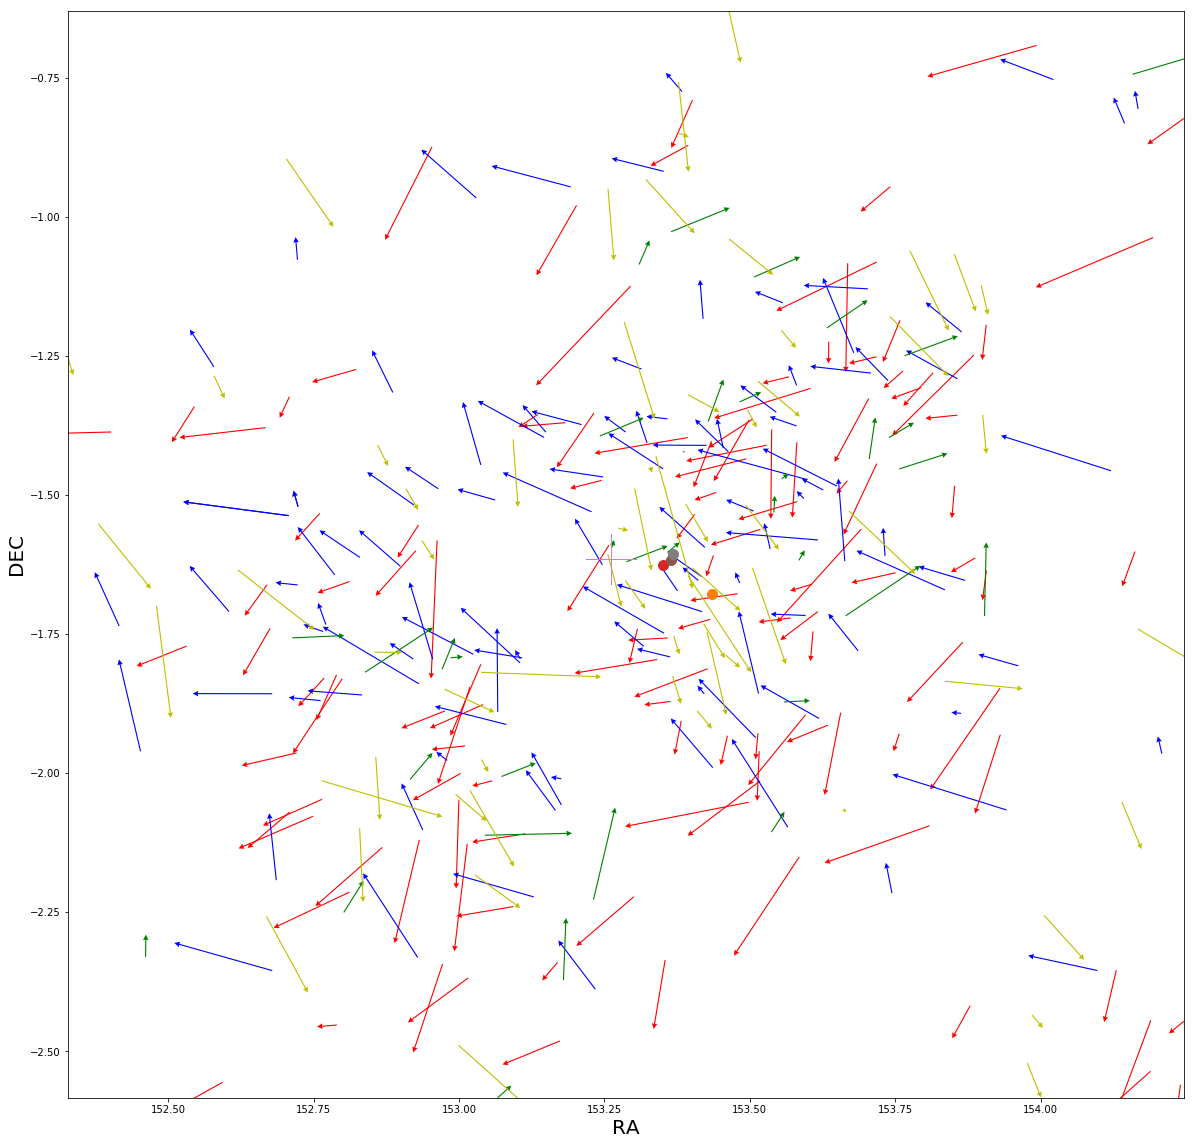

In [99]:
fig, axs = plt.subplots(1,1,figsize=(20,20))

nsec = 4
dtheta = 360./nsec 
c=['r','b','g','y']
ax=axs
for i in range(0,nsec):
    ith= (theta >=(i*dtheta)-180.) & (theta < (i+1)*dtheta-180.)
    stari=star[ith]
 #   print([np.fmod(i,2),((i//2))])
#    ax=axs[np.fmod(i,2),((i//2))]
    q=ax.quiver(stari.ra,stari.dec,stari.pmra,stari.pmdec,headwidth=5,headlength=5,width=0.001,scale=30,color=c[i])
    ax.axis([xmin, xmax, ymin, ymax])
    ax.set_xlabel('RA',fontsize=20)
    ax.set_ylabel("DEC",fontsize=20)
    ax.plot(ra0,dec0,marker='+',markersize=50)
    ax.plot(np.median(stari.ra),np.median(stari.dec),marker='o',markersize=10)
#    q=ax.quiver(np.median(stari.ra),np.median(stari.dec),np.median(stari.pmra),np.median(stari.pmdec),headwidth=10,headlength=10,width=0.01,scale=10)
    print([np.fmod(i,2),((i//2))],np.median(stari.ra)-ra0,np.median(stari.dec)-dec0,np.median(stari.pmra),np.median(stari.pmdec))